In [128]:
import numpy as np
from scipy import fft, optimize
import statistics as st
from matplotlib.widgets import Slider
import matplotlib.pyplot as plt
from IPython.display import display, Math

# Data

In [135]:
# Positions
# sddsconvert -ascii [file.sdds] [filename]
# /operations/app_store/Ramps/MADX/Au23-100GeV.../Blue/twiss.out Au23-10
init_turn = 10 # Starting turn
BPMx = np.loadtxt('BPMx.csv', delimiter=',')[:, init_turn:]
BPMy = np.loadtxt('BPMy.csv', delimiter=',')[:, init_turn:]

N_BPMx, N_turns = np.shape(BPMx) #(168, 1014)
N_BPMy, _ = np.shape(BPMy) #(167, 1014)

#Tunes
Nu_x_meas, Nu_y_meas = 28.235001748, 29.2290029334
nu_x_meas, nu_y_meas = Nu_x_meas%1, Nu_y_meas%1

x = np.linspace(init_turn, N_turns, N_turns)
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns

Standard deviation of First Horizontal BPM = 0.10470338709531711


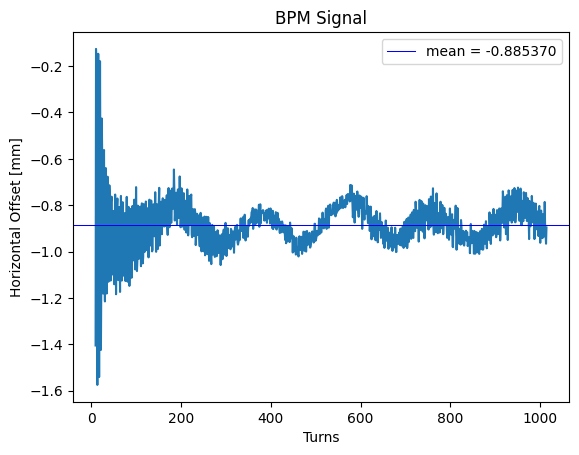

In [136]:
BPMx0 = BPMx[0]
#0, 20, 163

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print("Standard deviation of First Horizontal BPM =", BPMx0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMx0)
plt.axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
plt.xlabel("Turns")
plt.ylabel("Horizontal Offset [mm]")
plt.title("BPM Signal")
plt.legend()
plt.show()

0.2331820910416228


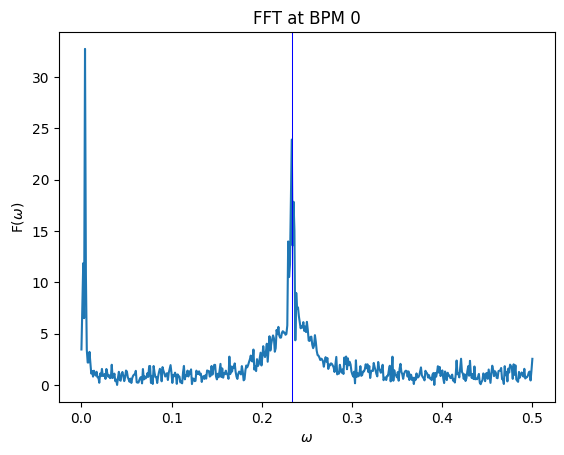

In [137]:
init_tune_index = 10 # Starting tune index
BPMX0 = np.abs(fft.rfft(BPMx0)[1:])
BPMx0_Tune_scipy = Omega[np.argmax(BPMX0[init_tune_index:])] + init_tune_index/N_turns
print(BPMx0_Tune_scipy)
plt.plot(Omega, BPMX0)
plt.axvline(x = BPMx0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%BPMx0_Tune_scipy)
plt.title("FFT at BPM 0")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

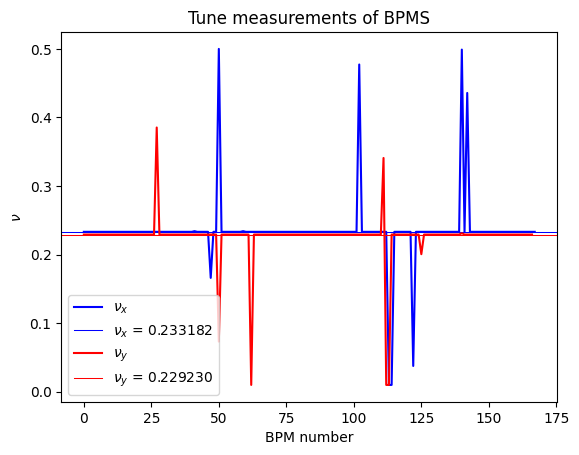

In [138]:
# Scipy to figure out tune
init_tune_index = 10 # Starting tune index
BPMx_Tune_Map = np.zeros(N_BPMx)
for i in range(N_BPMx):
    BPMX = np.abs(fft.rfft(BPMx[i])[1:]) 
    BPMx_Tune_Map[i] = Omega[np.argmax(BPMX[init_tune_index:])] + init_tune_index/N_turns
    # BPM 113 had a flat line

BPMy_Tune_Map = np.zeros(N_BPMy)
for i in range(N_BPMy):
    BPMY = np.abs(fft.rfft(BPMy[i])[1:])
    BPMy_Tune_Map[i] = Omega[np.argmax(BPMY[init_tune_index:])] + init_tune_index/N_turns

nu_x, nu_y = st.mode(BPMx_Tune_Map), st.mode(BPMy_Tune_Map)
#Difference from collision
delta_nu_x, delta_nu_y = abs(nu_x_meas - nu_x), abs(nu_y_meas - nu_y)

plt.plot(BPMx_Tune_Map, color = 'b', label = r"$\nu_x$")
plt.axhline(y = nu_x, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%nu_x)
plt.plot(BPMy_Tune_Map, color = 'r', label = r"$\nu_y$")
plt.axhline(y = nu_y, color = 'r', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%nu_y)
plt.xlabel("BPM number")
plt.ylabel(r"$\nu$")
plt.title("Tune measurements of BPMS")
plt.legend()
plt.show()

In [139]:
def Bad_Bpms(Tune_Map, nu, N_BPM):
    Tune_Offset = np.abs(Tune_Map - np.ones(N_BPM)*nu)
    Bad_BPM = []
    for i, offset in enumerate(Tune_Offset):
        if offset > 0:
            Bad_BPM.append(i)
    return Bad_BPM

Bad_BPMx = Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx)
Bad_BPMy = Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy)

# Betatron Function in terms of $A^2$

In [140]:
# Castro Paper
def Castro(nu, N_BPMs, Bad_bpms, BPM):
    C = np.zeros(N_BPMs)
    S = np.zeros(N_BPMs)
    
    omega = 2*np.pi*nu
    res = np.zeros(N_BPMs)
    for i in range(N_turns):
        C += BPM[:, i]*np.cos(omega*i)
        S += BPM[:, i]*np.sin(omega*i)
    A = 2*np.sqrt(C**2 + S**2)/N_turns

    # Get rid of bad bpms
    for i in Bad_bpms:
        # Look for the nearest good bpm neighbors and take the average:
        lo, hi = i, i
        while lo in Bad_bpms: 
            lo -= 1
            if lo < 0: lo = N_BPMs
        while hi in Bad_bpms: 
            hi += 1
            if hi > N_BPMs: hi = 0
        A[i] = (A[lo] - A[hi])/2
    res = A**2
    return res

BPMx_Asq_Map = Castro(nu_x, N_BPMx, Bad_BPMx, BPMx)
BPMy_Asq_Map = Castro(nu_y, N_BPMy, Bad_BPMy, BPMy)

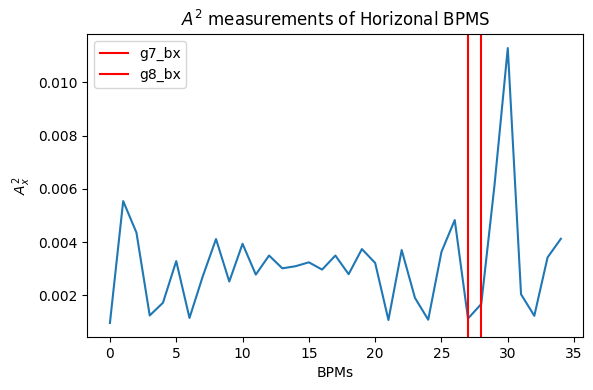

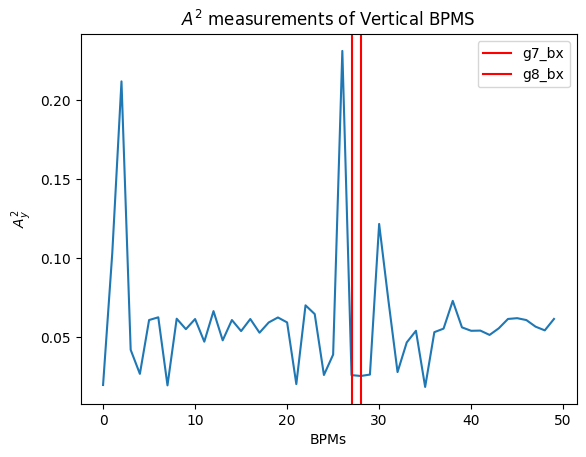

In [141]:
# Plot
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)
init_bpmx = 0
final_bpmx = 35#N_BPMx
x_BPM = np.linspace(0, N_BPMx, N_BPMx + 1)
plot_BPMx_Asq_Map, = plt.plot(x_BPM[init_bpmx: final_bpmx], BPMx_Asq_Map[init_bpmx: final_bpmx])

plt.xlabel("BPMs")
plt.ylabel(r"$A_x^2$")
plt.title(r"$A^2$ measurements of Horizonal BPMS")

# # # Add Sliders
# ax_tunex_slider = plt.axes([0.1, 0.1, .75, 0.025])
# tunex_slider = Slider(ax_tunex_slider, r"$\nu_x$", 0.2, .25, nu_x)
# ax_tuney_slider = plt.axes([0.1, 0.05, .75, 0.025])
# tuney_slider = Slider(ax_tuney_slider, r"$\nu_y$", 0.2, .25, nu_y)

# def update(val):
#     nu_x = tunex_slider.val
#     BPMx_Asq_Map = Castro(nu_x, N_BPMx, BPMx)
#     plot_BPMx_Asq_Map.set_ydata(BPMx_Asq_Map[init_bpmx: final_bpmx])
#     nu_y = tuney_slider.val
#     BPMy_Asq_Map = Castro(nu_y, N_BPMy, BPMy)
#     plot_BPMy_Asq_Map.set_ydata(BPMy_Asq_Map[init_bpmy: final_bpmy])
    
# tunex_slider.on_changed(update)
# tuney_slider.on_changed(update)

BPM26_no = 26
BPM27_no = 27
plt.axvline(x = 27, color = 'r', linestyle = '-', label = "g7_bx")
plt.axvline(x = 28, color = 'r', linestyle = '-', label = "g8_bx")
plt.legend()

plt.show()

init_bpmy = 0
final_bpmy = 50 #N_BPMy
y_BPM = np.linspace(0, N_BPMy, N_BPMy + 1)
plot_BPMy_Asq_Map, = plt.plot(y_BPM[init_bpmy: final_bpmy], BPMy_Asq_Map[init_bpmy: final_bpmy])
plt.xlabel("BPMs")
plt.ylabel(r"$A_y^2$")
plt.title(r"$A^2$ measurements of Vertical BPMS")

plt.axvline(x = 27, color = 'r', linestyle = '-', label = "g7_bx")
plt.axvline(x = 28, color = 'r', linestyle = '-', label = "g8_bx")
plt.legend()

plt.show()

# Betatron Function around IP

Determine constant a from $\beta = \frac{A^2}{a^2}$

\begin{equation*}
M_{drift} = 
\begin{bmatrix}
C & S\\
C' & S'
\end{bmatrix}
=
\begin{bmatrix}
1 & L\\
0 & 1
\end{bmatrix}
\end{equation*}

\begin{equation*}
\Rightarrow
M_{twiss} = 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\end{equation*}

Between BPM 26 and BPM 27:
\begin{equation*}
\begin{bmatrix}
\beta_2 \\
\alpha_f \\
\gamma_f \\
\end{bmatrix}
= 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\alpha_i \\
\gamma_i \\
\end{bmatrix}
\end{equation*}

$\Rightarrow \beta_2 = \beta_1 - 2L\alpha_i + L^2 \gamma_i$\
$\Rightarrow \alpha_1 = \frac{\beta_1}{L} \pm \sqrt{\frac{\beta_1\beta_2}{L} - 1}$\
$\Rightarrow \alpha_2 = \alpha_1 - L\gamma_1$\
Where $\gamma_1 = \frac{1 + \alpha_1^2}{\beta_1}$

Between BPM 27 and BPM 28:\
\begin{equation*}
\begin{bmatrix}
\beta_3 \\
\alpha_f \\
\gamma_f \\
\end{bmatrix}
= 
\begin{bmatrix}
1 & -2L & L^2 \\
0 & 1 & -L \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\beta_2 \\
\alpha_2 \\
\gamma_2 \\
\end{bmatrix}
\end{equation*}
$\Rightarrow \beta_3 = \beta_2 - 2L\alpha_2 + L^2 \gamma_2$

Since everything is known except a, solve for a using some root finding method

/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_49289/3041192398.py:14: RuntimeWarning: invalid value encountered in sqrt
  alpha26 = b26/L26_27 - np.sqrt(b26*b27/L26_27**2 - 1)


-1657.671695088811 51.975245150859834
51.975245150859834


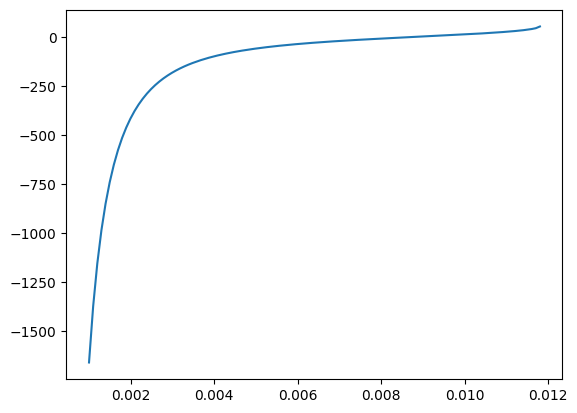

0.008908518384865602


In [116]:
s_BPM25 = 614.421244783004
s_BPM26 = 631.118653949618
s_BPM27 = 647.771401949618
s_BPM28 = 664.468811116232
L25_26 = abs(s_BPM25 - s_BPM26)
L26_27 = abs(s_BPM26 - s_BPM27)
L27_28 = abs(s_BPM27 - s_BPM28)

def f(a):
    b25 = BPMx_Asq_Map[25]/a**2
    b26 = BPMx_Asq_Map[26]/a**2
    b27 = BPMx_Asq_Map[27]/a**2
    b28 = BPMx_Asq_Map[28]/a**2
    alpha26 = b26/L26_27 - np.sqrt(b26*b27/L26_27**2 - 1)
    gamma26 = (1 + alpha26**2)/b26
    alpha27 = alpha26 - L26_27*gamma26
    gamma27 = (1 + alpha27**2)/b27
    return b27 - b28 - 2*L27_28*alpha27 + L27_28**2*gamma27

A_const = np.linspace(.001, .1, 1000)
f_a = f(A_const)
f_a = f_a[np.logical_not(np.isnan(f_a))]
N_f_a = len(f_a)
print(f_a[0], f_a[-1])
print(np.max(f_a))
plt.plot(A_const, f(A_const))
plt.show()

a_opt = optimize.bisect(f, A_const[0], A_const[-1])
print(a_opt)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


After shift:


<IPython.core.display.Math object>

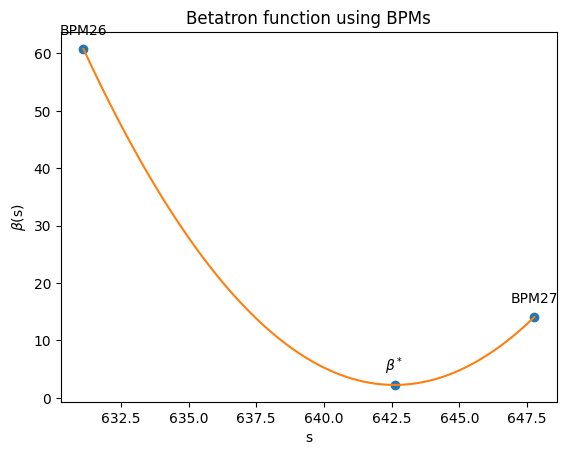

In [117]:
# Determine Betatron function:
a_const = a_opt
beta_BPM26, beta_BPM27 = BPMx_Asq_Map[26]/a_const**2, BPMx_Asq_Map[27]/a_const**2
alpha_BPM26 = beta_BPM26/L12 + np.sqrt(beta_BPM26*beta_BPM27/L12**2 - 1)
display(Math(r"\beta_{26} = %f"%beta_BPM26))
display(Math(r"\alpha_{26} = %f"%alpha_BPM26))
display(Math(r"\beta_{27} = %f"%beta_BPM27))
 
s_star = s_BPM26 + alpha_BPM26*beta_BPM26/(alpha_BPM26**2 + 1)
beta_star = beta_BPM26/(alpha_BPM26**2 + 1)
display(Math(r"\beta^* = %f"%beta_star))
display(Math(r"s^* = %f"%s_star))

def calc_parabola_vertex(x1, y1, x2, y2, x3, y3):
    denom = (x1-x2) * (x1-x3) * (x2-x3)
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
    C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom
    return A,B,C
A, B, C = calc_parabola_vertex(s_BPM26, beta_BPM26, s_star, beta_star, s_BPM27, beta_BPM27)
A_shift, B_shift, C_shift = calc_parabola_vertex(s_BPM26 - s_star, beta_BPM26, 0, beta_star, s_BPM27 - s_star, beta_BPM27)
print()
print("After shift:")
display(Math(r"%fx^2 + %dx + %f"%(A_shift, B_shift, C_shift)))

s_space = np.linspace(s_BPM26, s_BPM27, 1000)
Betatron = A*s_space**2 + B*s_space + C
plt.plot([s_BPM26, s_star, s_BPM27], [beta_BPM26, beta_star, beta_BPM27], 'o')
for x, y, text in zip([s_BPM26, s_star, s_BPM27], [beta_BPM26, beta_star, beta_BPM27], ["BPM26", r"$\beta^*$", "BPM27"]):

    plt.annotate(text, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.plot(s_space, Betatron)
plt.title("Betatron function using BPMs")
plt.xlabel("s")
plt.ylabel(r"$\beta$(s)")
plt.show()